[Hugging Face](https://huggingface.co/)'s `transformers` [library](https://huggingface.co/docs/transformers/index) is a compilation of deep learning models, designed to allow users to quickly get started using and applying pretrained models to their data. Currently the library supports text, vision, audio and multimodal models. The library enjoys a large user base, and maybe be used together with Hugging Face's model, dataset, spaces and API services.

[PADL](https://padl.ai/) is a functional model builder for [PyTorch](https://pytorch.org/) allowing for full export of model pipelines including preprocessing, forward pass and postprocessing. In addition PADL offers some super handy usability features, such as operator pipeline building via operator overloading, interactive/ notebook friendly design and tools for pipeline inspection and debugging. 

Hugging Face and PADL have some superficial similarities, in particular, with regards to Hugging Face's pipelines and PADL's pipelines. Both libraries handle preprocessing, forward pass and postprocessing inside one object, both provide the possibility to "get started" with models far quicker than if using vanilla PyTorch implementations. PADL, possesses one major advantage, however - namely, the PADL functional model building formalism. PADL allows developers to flexible combine a variety of functionality from the entire Python ecosystem, and build this into a single pipeline including PyTorch layers. This gives completely customizable pipelines, which can nevertheless be loaded with a single command. In addition, each pipeline is serialized separately and individually - there is no attempt made by the PADL package, to compile "all the common use-cases". This leads to very nicely self contained code, in which hyperparameters, and pipeline structure are extremely easy to view and follow, and easy to debug and experiment with.

A disadvantage which PADL has, is that it does not come together with a model hub. That means models need to be fetched, or trained, and subsequently combined into new pipelines, if desired. This is not necessarily a bad thing, because PADL has enough flexibility to allow elements of pipelines from Hugging Face to be combined into PADL pipelines. In this tutorial we demonstrate this on an image annotation example using the [CoCo](https://cocodataset.org/#home) dataset.

Downloads and installations for this tutorial

In [ ]:
!wget http://images.cocodataset.org/zips/train2014.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip train2014.zip
!unzip annotations_trainval2014.zip
!rm train2014.zip
!rm annotations_trainval2014.zip

In [ ]:
!python3.9 -m pip install padl
!python3.9 -m pip install transformers

We're going to make use of two "pipelines" from the hugging-face package, let's initialize them.
In the case of the text-generation pipeline, we're just going to use the tokenizer.

In [1]:
from transformers import pipeline
import padl

tg = pipeline('text-generation')
pl = pipeline('image-classification')

No model was supplied, defaulted to gpt2 (https://huggingface.co/gpt2)
No model was supplied, defaulted to google/vit-base-patch16-224 (https://huggingface.co/google/vit-base-patch16-224)


We'll do some light preprocessing for this notebook, adding the image-captions and image paths to a list of data points.

In [2]:
import pandas
import random
import json

with open('annotations/captions_train2014.json') as f:
    data = json.load(f)

image_lookup = {}
for image in data['images']:
    image_lookup[image['id']] = 'train2014/' + image['file_name']
    
annotations = []
for annotation in data['annotations']:
    annotations.append({'image': image_lookup[annotation['image_id']], 'caption': annotation['caption']})
    
annotations = pandas.DataFrame(annotations)
all_images = annotations['image'].unique().tolist()

random.shuffle(all_images)

train_images = all_images[:-250]
valid_images = all_images[-250:]

train_annotations = annotations[annotations['image'].isin(train_images)].to_dict('split')['data']
valid_annotations = annotations[annotations['image'].isin(valid_images)].to_dict('split')['data']
for x in train_annotations:
    if not x[1].endswith('.'):
        x[1] += '.'

In this tutorial we're going to combine a custom language model layer with some pretrained layers from `transformers`. 
The custom layers are in the next cell. In order to use them in PADL, we only need to decorate them with `@padl.transform`.

In [3]:
import torch


@padl.transform
class SimpleRNN(torch.nn.Module):
    def __init__(self, rnn, proj, embed):
        super().__init__()
        self.rnn = rnn
        self.proj = proj
        self.embed = embed
        
    def forward(self, hidden, input_ids):
        return self.proj(self.rnn(self.embed(input_ids), hidden)[0])
        
        
@padl.transform
class Greedy(torch.nn.Module):
    def __init__(self, rnn, proj, embed, end, max_len=20):
        super().__init__()
        self.rnn = rnn
        self.proj = proj
        self.embed = embed
        self.end = end
        self.max_len = max_len
        
    def forward(self, hidden):
        input_ids = [self.proj(hidden).topk(1)[1].item()]
        it = 0
        while True:
            hidden = self.rnn(self.embed(torch.tensor([input_ids[-1]])[None, :]), hidden)[0]
            input_ids.append(self.proj(hidden).squeeze().topk(1)[1].item())
            if input_ids[-1] == self.end:
                break
            if it >= self.max_len:
                break
            it +=1
        return torch.tensor(input_ids[:-1])

We can also wrap `torch` layers directly with `padl.transform`

In [4]:
conditioner = padl.transform(torch.nn.Linear(768, 512))
rnn = torch.nn.GRU(64, 512, 1, batch_first=True)
embed = torch.nn.Embedding(tg.tokenizer.vocab_size, 64)
proj = torch.nn.Linear(512, tg.tokenizer.vocab_size)

The following two layers will be used for inference and training respectively, with tied weights.

In [5]:
generator = Greedy(rnn, proj, embed, tg.tokenizer.encode('.#')[0])
logits = SimpleRNN(rnn, proj, embed)

In order to train an image captioner, we use image features from the default image-classification model in Hugging Face. The PyTorch layer is `pl.model.vit` inside the Hugging Face pipeline `pl`. We extract the last hidden state
and use that to represent the information in the images. 

The full pipeline involves applying the preprocessing of `pl.preprocess`, extracting the variable `pixel_values`,
creating a batch of data, applying the model, and extracting the hidden state. This can be done using the PADL
operator `>>` (function composition).

In [6]:
pl.model.config.output_hidden_states = True
image_features = (
    padl.transform(pl.preprocess)
    >> padl.transform(lambda x: x['pixel_values'][0])
    >> padl.batch
    >> padl.transform(pl.model.vit)
    >> padl.transform(lambda x: x.last_hidden_state[:, 0, :])
)
image_features

Compose - "image_features":

      │
      ▼ image
   0: preprocess                            
      │
      ▼ x
   1: lambda x: x['pixel_values'][0]        
      │
      ▼ args
   2: Batchify(dim=0)                       
      │
      ▼ (pixel_values, head_mask, output_attentions, output_hidden_states, interpolate_pos_encoding, return_dict)
   3: ViTModel(pl.model.vit)                
      │
      ▼ x
   4: lambda x: x.last_hidden_state[:, 0, :]

We can define custom PADL transforms by decorating regular functions with `@padl.transform`. In this case, 
our custom transformations are a loss function and padding.

In [7]:
@padl.transform
def myloss(x, y):
    targets, lens = y
    loss = 0
    for i in range(x.shape[0]):
        loss += torch.nn.functional.cross_entropy(x[i, :lens[i], :], targets[i, :lens[i]])
    return loss.div(x.shape[0])


@padl.transform
def mypad(x):
    len_ = len(x)
    x = x[:15]
    x = torch.cat([x, torch.zeros(15 - len(x))]).type(torch.long)
    return x, len_

For the text preprocessing, we use the tokenizer from the default text generation pipeline in Hugging Face `tg`.
In that we save ourselves the effort of calibrating a tokenizer ourselves. This demonstrates the flexibility of PADL, allowing us to use existing facilities already in the ecosystem and leverage these to great effect.

In [8]:
text_preprocess = (
    padl.transform(tg.tokenizer.encode)
    >> padl.transform(torch.tensor)
    >> mypad
    >> padl.batch
)

Now we can create the pipelines we'll need to train the image captioner. We can apply 2 PADL transforms or pipelines to a tuple of data using the operator `/`. That allows us to combine the image-feature and text-preprocessing pipelines in parallel, and pass the outputs to the custom PyTorch layers we created above. The `training_model`
passes the outputs of the RNN to the loss function, whereas the `inference_model` passes those outputs to the RNN and performs a greedy search procedure to get a likely annotation for an unseen image. The output is passed to the decoding method of the Hugging Face tokenizer.

In [9]:
training_model = (
    (image_features >> conditioner >> padl.same.unsqueeze(0)) / 
        (padl.transform(lambda x: '!' + x) >> text_preprocess >> padl.same[0])
    >> logits
)

inference_model = (
    image_features
    >> conditioner 
    >> padl.same.unsqueeze(1)
    >> generator
    >> padl.transform(tg.tokenizer.decode)
)

loss = (
    training_model + (padl.same[1] >> padl.transform(lambda x: x + '#') >> text_preprocess)
    >> myloss
)

Let's now train the model! An optimizer is created in the usual way. We choose not to finetune the weights of the image model, as they have already been well trained on a related image classification task.

In [10]:
import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

for p in pl.model.vit.parameters():
    p.requires_grad = False
    
o = torch.optim.Adam([p for p in loss.pd_parameters() if p.requires_grad], lr=0.001)
loss.pd_to('cuda')
it = 0

/home/duncan/padl/padl/transforms.py:1217: RuntimeWarning: Could not get closurevars (<built-in method tensor of type object at 0x7f842816e1a0> is not a Python function). This is usually fine as closurevars are only needed for user defined transforms.
  warn(f'Could not get closurevars ({exc}). This is usually fine as closurevars are only '


In order to iterate through the data, we use the `.train_apply` and `.eval_apply` methods, depending if we want gradients or not. The output of the `loss` transform is simply a PyTorch tensor, so we can do all of the customary things in training. You'll notice that we don't need a dataloader here. That's because PADL handles this logic internally, meaning less boilerplate, and more focus on the science.

In [11]:
epochs = 20
it = 0
for _ in range(epochs):
    try:
        for l_ in loss.train_apply(train_annotations, batch_size=250, num_workers=5):
            o.zero_grad()
            l_.backward()
            o.step()
            if it % 10 == 0:
                print(f'TRAIN iteration: {it}; loss; {l_};')

            if it % 1000 == 0:
                losses = loss.eval_apply(valid_annotations, batch_size=250, num_workers=5)
                valid_loss = sum([x.item() for x in losses]) / len(losses)
                print(f'VALID iteration: {it}; loss; {valid_loss};')
            it += 1
    except KeyboardInterrupt:
        break

TRAIN iteration: 0; loss; 10.827377319335938;
VALID iteration: 0; loss; 10.740452448527018;
TRAIN iteration: 10; loss; 6.033793926239014;
TRAIN iteration: 20; loss; 5.384777545928955;
TRAIN iteration: 30; loss; 5.133225440979004;
TRAIN iteration: 40; loss; 4.900012969970703;
TRAIN iteration: 50; loss; 4.633405685424805;
TRAIN iteration: 60; loss; 4.28609561920166;
TRAIN iteration: 70; loss; 4.149620532989502;
TRAIN iteration: 80; loss; 4.472349643707275;
TRAIN iteration: 90; loss; 4.165567874908447;
TRAIN iteration: 100; loss; 4.1478729248046875;
TRAIN iteration: 110; loss; 3.888875961303711;
TRAIN iteration: 120; loss; 3.9358842372894287;
TRAIN iteration: 130; loss; 4.2183003425598145;
TRAIN iteration: 140; loss; 4.4809393882751465;
TRAIN iteration: 150; loss; 4.43829345703125;
TRAIN iteration: 160; loss; 4.103472709655762;
TRAIN iteration: 170; loss; 3.8528003692626953;
TRAIN iteration: 180; loss; 3.650216817855835;
TRAIN iteration: 190; loss; 3.850703001022339;
TRAIN iteration: 200;

Now that we've trained the model for a bit, let's test the results of the training. We test on the `inference_model`,
since it contains the inference procedure; its weights are tied to the `training_model`.

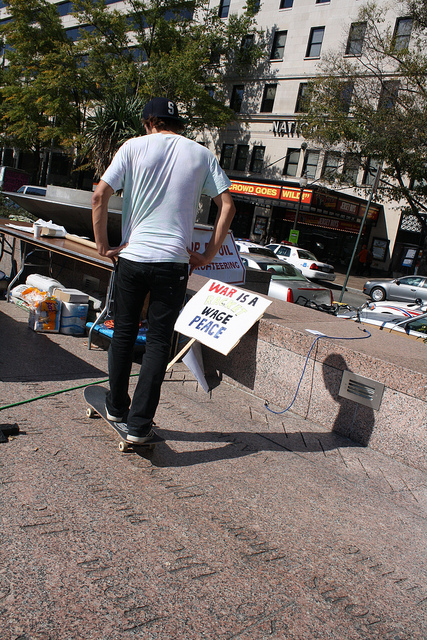

'A man is skateboarding down a street'

In [18]:
import PIL.Image
from IPython.display import display
import random

image = valid_annotations[random.randrange(len(valid_annotations))][0]

display(PIL.Image.open(image))
inference_model.infer_apply(image)

I'm fairly happy with those results, so I'm going to save the `inference_model` pipeline for use later on. We now
see a super powerful aspect of PADL. ***The saved result contains everything needed to reuse the model later on!***.

In [19]:
inference_model.pd_save('coco_model.padl', force_overwrite=True)

saving torch module to coco_model.padl/4.pt
saving torch module to coco_model.padl/6.pt
saving torch module to coco_model.padl/8.pt


That means that the following cell, works in a completely new session, with no preparatory code or imports necessary. As a result, the trained model is super portable and reusable. You can share it, load it into another notebook, plug it directly into the production environment etc..

In [20]:
reloaded = padl.load('coco_model.padl')

No model was supplied, defaulted to google/vit-base-patch16-224 (https://huggingface.co/google/vit-base-patch16-224)
No model was supplied, defaulted to gpt2 (https://huggingface.co/gpt2)


loading torch module from coco_model.padl/4.pt
loading torch module from coco_model.padl/6.pt
loading torch module from coco_model.padl/8.pt


In this tutorial we showed that PADL can be combined to great effect with the Hugging Face `transformers` library as well the rest of the Python ecosystem. It's a great tool for sharing research results, collaborating, tracking model lineage, and inspecting past models for their implementation details. It can be combined with [TorchServe](https://medium.com/padl-developer-blog/one-line-of-code-serves-your-pytorch-model-in-torchserve-using-padl-9e5990493181) an [PyTorch Lightning](), and [removes many pain points](https://medium.com/padl-developer-blog/deep-learning-made-simple-but-not-too-simple-with-padl-and-pytorch-703143b86093) in deep learning development. Watch this space for more information and tutorials on how to combine PADL with the PyTorch ecosystem and beyond.

**Happy PADL-ling!**